In [1]:
# Phishing Detection in Google Colab
# Run this in Colab: https://colab.research.google.com/

# Install required packages
# !pip install wordcloud
# !pip install seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
# nltk.download('punkt_tab') # Removed download for punkt_tab as it's not a standard NLTK package and causing issues

print("✅ All packages installed and imported successfully!")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\krish\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\krish\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\krish\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\krish\AppData\Roaming\nltk_data...


✅ All packages installed and imported successfully!


[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
# Create a comprehensive sample dataset for Colab
def create_sample_dataset():
    """Create a realistic phishing dataset for demonstration"""

    phishing_examples = [
        # Urgent action required
        "URGENT: Your bank account will be suspended within 24 hours. Verify now: http://secure-bank-verify.com",
        "Immediate action required: Unusual login detected. Secure your account: http://fake-security.com/login",
        "Account Alert: Multiple failed login attempts. Click here to review: http://phishing-bank.com/secure",

        # Prize winnings
        "Congratulations! You won $1,000,000 in the lottery! Claim your prize: http://claim-prize-now.com",
        "You are our lucky winner! Click here to claim your iPhone: http://free-gift-offer.com/redeem",
        "Cash prize waiting! You've been selected for a $500 gift card: http://exclusive-rewards.com/claim",

        # Security threats
        "Security Breach: Your password has been compromised. Reset now: http://fake-reset-portal.com",
        "ALERT: Suspicious activity detected on your account. Verify identity: http://security-verification.net",

        # Fake invoices/payments
        "Invoice #INV-98432 for $299.99 is pending. View details: http://fake-invoice-payment.com",
        "Payment confirmation required for order #ORD-76321: http://payment-verification-service.com",

        # Social engineering
        "Hi, I need your help urgently. Can you send me the documents? http://fake-file-share.com",
        "Your friend shared a photo with you. View it here: http://malicious-link-photos.com",

        # Fake job offers
        "You're hired! $5000/month remote job. Start immediately: http://fake-job-offer.com/accept",

        # Tech support scams
        "Microsoft Windows Alert: Virus detected. Download removal tool: http://fake-antivirus.com",
        "Apple iCloud Security: Unusual activity. Verify account: http://icloud-security-verification.com",

        # More phishing examples
        "Your PayPal account has been limited. Verify your information: http://paypal-secure-verify.com",
        "Amazon: Unusual login attempt. Secure your account: http://amazon-account-protection.com",
        "Netflix: Payment failed. Update your billing information: http://netflix-billing-update.com",
        "Facebook: Your account will be deleted. Confirm your identity: http://facebook-security-check.com",
        "Instagram: Someone tagged you in a photo. View it now: http://insta-photo-tag.com"
    ]

    legitimate_examples = [
        # Real business communications
        "Hi John, our meeting is scheduled for tomorrow at 2 PM in conference room B.",
        "Your Amazon order #123-4567890 has been shipped. Track your package: https://amazon.com/track",
        "Monthly newsletter: Check out our latest updates and features.",

        # Personal messages
        "Hey, are we still on for dinner tonight? Let me know what time works for you.",
        "Mom, can you send me that recipe for chocolate cake? Thanks!",
        "Team, please review the attached report and provide feedback by EOD.",

        # Real notifications
        "Your password was successfully changed. If this wasn't you, contact support.",
        "Welcome to our service! Confirm your email address to get started.",
        "Your monthly statement is now available. Log in to your account to view.",

        # Work communications
        "The project deadline has been extended to next Friday. Please adjust your schedules accordingly.",
        "Please find the meeting agenda attached. Looking forward to our discussion.",
        "Reminder: Company training session tomorrow at 10 AM in the main auditorium.",

        # Social media notifications
        "Your friend Sarah commented on your post: 'Great photo!'",
        "You have a new connection request on LinkedIn from Jane Doe.",
        "Your post received 15 likes and 3 comments.",

        # Real security alerts
        "New sign-in from Chrome on Windows. If this was you, you can ignore this message.",
        "Two-factor authentication has been enabled for your account.",
        "We noticed a new login to your account from a new device.",

        # More legitimate examples
        "Your delivery will arrive between 2-4 PM today. Track your package on our website.",
        "Thank you for your purchase! Your order confirmation is attached.",
        "Reminder: Your dental appointment is tomorrow at 3:00 PM.",
        "The software update is ready to install. Please save your work and restart.",
        "Your subscription will renew automatically on July 1st. No action needed."
    ]

    # Create DataFrame
    phishing_df = pd.DataFrame({
        'text': phishing_examples,
        'label': 1  # 1 for phishing
    })

    legitimate_df = pd.DataFrame({
        'text': legitimate_examples,
        'label': 0  # 0 for legitimate
    })

    df = pd.concat([phishing_df, legitimate_df], ignore_index=True)
    df = df.sample(frac=1).reset_index(drop=True)  # Shuffle

    return df

# Create and display the dataset
df = create_sample_dataset()
print("📊 Dataset created successfully!")
print(f"Dataset shape: {df.shape}")
print(f"Phishing emails: {len(df[df['label'] == 1])}")
print(f"Legitimate emails: {len(df[df['label'] == 0])}")

# Display first few rows
df.head(10)

📊 Dataset created successfully!
Dataset shape: (43, 2)
Phishing emails: 20
Legitimate emails: 23


,text,label
0,Your PayPal account has been limited. Verify y...,1
1,"Hey, are we still on for dinner tonight? Let m...",0
2,Microsoft Windows Alert: Virus detected. Downl...,1
3,"Hi John, our meeting is scheduled for tomorrow...",0
4,Monthly newsletter: Check out our latest updat...,0
5,New sign-in from Chrome on Windows. If this wa...,0
6,You have a new connection request on LinkedIn ...,0
7,Your friend shared a photo with you. View it h...,1
8,URGENT: Your bank account will be suspended wi...,1
9,"Congratulations! You won $1,000,000 in the lot...",1


🔍 EXPLORATORY DATA ANALYSIS


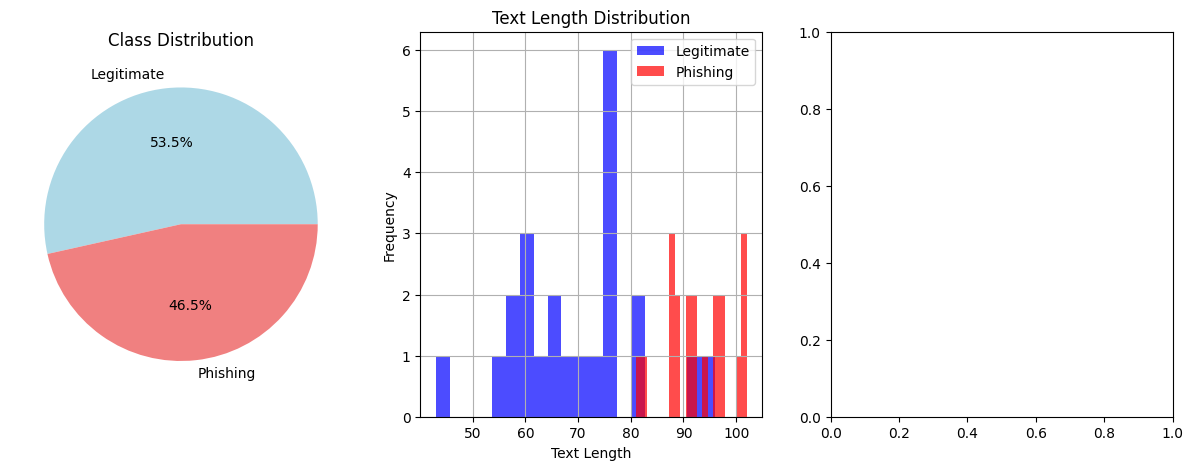

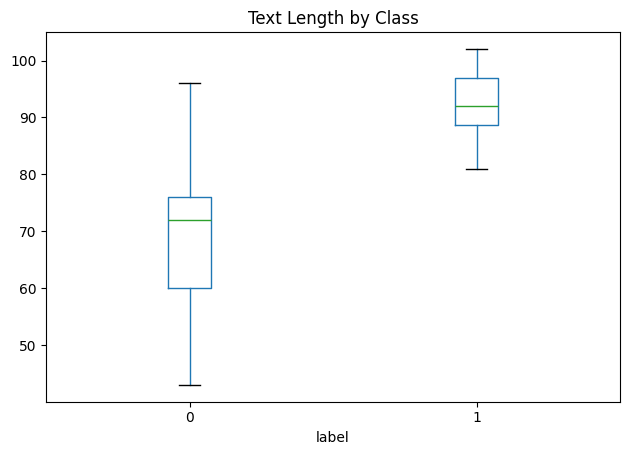


📏 Text Length Statistics:
       count       mean        std   min    25%   50%   75%    max
label                                                             
0       23.0  69.826087  12.360686  43.0  60.00  72.0  76.0   96.0
1       20.0  92.900000   6.086223  81.0  88.75  92.0  97.0  102.0


In [3]:
# Exploratory Data Analysis
print("🔍 EXPLORATORY DATA ANALYSIS")
print("=" * 50)

# Class distribution
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
class_dist = df['label'].value_counts()
colors = ['lightblue', 'lightcoral']
plt.pie(class_dist.values, labels=['Legitimate', 'Phishing'], autopct='%1.1f%%', colors=colors)
plt.title('Class Distribution')

# Text length analysis
df['text_length'] = df['text'].apply(len)

plt.subplot(1, 3, 2)
df[df['label'] == 0]['text_length'].hist(alpha=0.7, label='Legitimate', color='blue', bins=20)
df[df['label'] == 1]['text_length'].hist(alpha=0.7, label='Phishing', color='red', bins=20)
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Text Length Distribution')
plt.legend()

plt.subplot(1, 3, 3)
df.boxplot(column='text_length', by='label', grid=False)
plt.title('Text Length by Class')
plt.suptitle('')

plt.tight_layout()
plt.show()

# Text length statistics
print("\n📏 Text Length Statistics:")
print(df.groupby('label')['text_length'].describe())

In [4]:
# Text Preprocessing
class TextPreprocessor:
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
        # Initialize TreebankWordTokenizer explicitly
        from nltk.tokenize.treebank import TreebankWordTokenizer
        self.tokenizer = TreebankWordTokenizer()


    def preprocess_text(self, text):
        """Clean and preprocess text"""
        if pd.isna(text):
            return ""

        # Convert to lowercase
        text = str(text).lower()

        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', 'URL', text, flags=re.MULTILINE)

        # Remove email addresses
        text = re.sub(r'\S+@\S+', 'EMAIL', text)

        # Remove special characters but keep basic punctuation
        text = re.sub(r'[^a-zA-Z\s.!?]', '', text)

        # Tokenize using the explicit TreebankWordTokenizer
        tokens = self.tokenizer.tokenize(text)

        # Remove stopwords and short tokens
        tokens = [token for token in tokens if token not in self.stop_words and len(token) > 2]

        # Lemmatize
        tokens = [self.lemmatizer.lemmatize(token) for token in tokens]

        return ' '.join(tokens)

# Initialize preprocessor
preprocessor = TextPreprocessor()

# Apply preprocessing
print("🔄 Preprocessing text data...")
df['cleaned_text'] = df['text'].apply(preprocessor.preprocess_text)

# Show examples
print("\n📝 Text Preprocessing Examples:")
print("=" * 60)
for i in range(3):
    print(f"Original {i+1}: {df['text'].iloc[i][:80]}...")
    print(f"Cleaned {i+1}:  {df['cleaned_text'].iloc[i][:80]}...")
    print("-" * 60)

print(f"\n✅ Preprocessing completed! Final dataset size: {len(df)} samples")

🔄 Preprocessing text data...

📝 Text Preprocessing Examples:
Original 1: Your PayPal account has been limited. Verify your information: http://paypal-sec...
Cleaned 1:  paypal account limited. verify information URL...
------------------------------------------------------------
Original 2: Hey, are we still on for dinner tonight? Let me know what time works for you....
Cleaned 2:  hey still dinner tonight let know time work...
------------------------------------------------------------
Original 3: Microsoft Windows Alert: Virus detected. Download removal tool: http://fake-anti...
Cleaned 3:  microsoft window alert virus detected. download removal tool URL...
------------------------------------------------------------

✅ Preprocessing completed! Final dataset size: 43 samples


In [5]:
# Feature Extraction with TF-IDF
print("🔧 Feature Extraction with TF-IDF")
print("=" * 50)

# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),  # Use single words and bigrams
    stop_words='english',
    min_df=2,  # Ignore terms that appear in less than 2 documents
    max_df=0.8  # Ignore terms that appear in more than 80% of documents
)

# Transform text to features
X_tfidf = vectorizer.fit_transform(df['cleaned_text'])
y = df['label']

print(f"Feature matrix shape: {X_tfidf.shape}")
print(f"Number of features: {len(vectorizer.get_feature_names_out())}")

# Show some feature names
feature_names = vectorizer.get_feature_names_out()
print(f"\nSample features: {feature_names[:20]}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n📊 Data Split:")
print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")
print(f"Training features: {X_train.shape[1]}")

🔧 Feature Extraction with TF-IDF
Feature matrix shape: (43, 48)
Number of features: 48

Sample features: ['account' 'account url' 'action' 'activity' 'alert' 'amazon' 'attached'
 'claim' 'click' 'confirm' 'confirmation' 'detected' 'failed' 'friend'
 'identity' 'identity url' 'information' 'information url' 'login'
 'meeting']

📊 Data Split:
Training samples: 34
Testing samples: 9
Training features: 48


In [6]:
# Model Training
print("🤖 Training Machine Learning Models")
print("=" * 50)

models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Multinomial Naive Bayes': MultinomialNB(),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100)
}

# Train all models
trained_models = {}
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    trained_models[name] = model
    print(f"✅ {name} training completed!\n")

print("🎯 All models trained successfully!")

🤖 Training Machine Learning Models
Training Logistic Regression...
✅ Logistic Regression training completed!

Training Multinomial Naive Bayes...
✅ Multinomial Naive Bayes training completed!

Training Random Forest...
✅ Random Forest training completed!

🎯 All models trained successfully!


In [7]:
# Model Evaluation
print("📊 Model Evaluation")
print("=" * 50)

results = {}

for name, model in trained_models.items():
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Store results
    results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }

    print(f"\n{name} Results:")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")

    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')
    print(f"CV F1-Score: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# Create comparison table
results_df = pd.DataFrame(results).T
print("\n" + "="*60)
print("📈 MODEL COMPARISON SUMMARY")
print("="*60)
print(results_df.round(4))

📊 Model Evaluation

Logistic Regression Results:
Accuracy:  0.8889
Precision: 0.8000
Recall:    1.0000
F1-Score:  0.8889
CV F1-Score: 0.9314 ± 0.0859

Multinomial Naive Bayes Results:
Accuracy:  0.7778
Precision: 0.6667
Recall:    1.0000
F1-Score:  0.8000
CV F1-Score: 0.8529 ± 0.0837

Random Forest Results:
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1-Score:  1.0000
CV F1-Score: 0.9429 ± 0.0700

📈 MODEL COMPARISON SUMMARY
                         accuracy precision recall  f1_score  \
Logistic Regression      0.888889       0.8    1.0  0.888889   
Multinomial Naive Bayes  0.777778  0.666667    1.0       0.8   
Random Forest                 1.0       1.0    1.0       1.0   

                                         predictions  \
Logistic Regression      [0, 0, 1, 0, 1, 1, 1, 1, 0]   
Multinomial Naive Bayes  [1, 0, 1, 0, 1, 1, 1, 1, 0]   
Random Forest            [0, 0, 1, 0, 1, 0, 1, 1, 0]   

                                                             probabilities  
Log

📊 Creating Visualizations


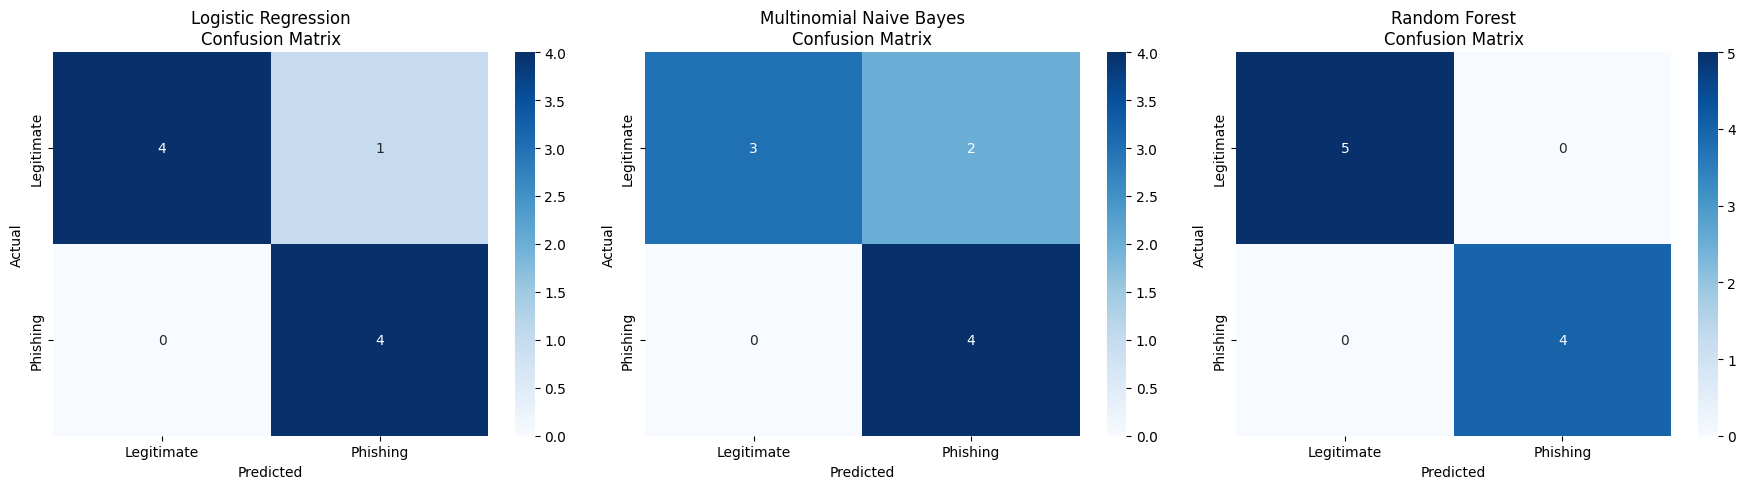

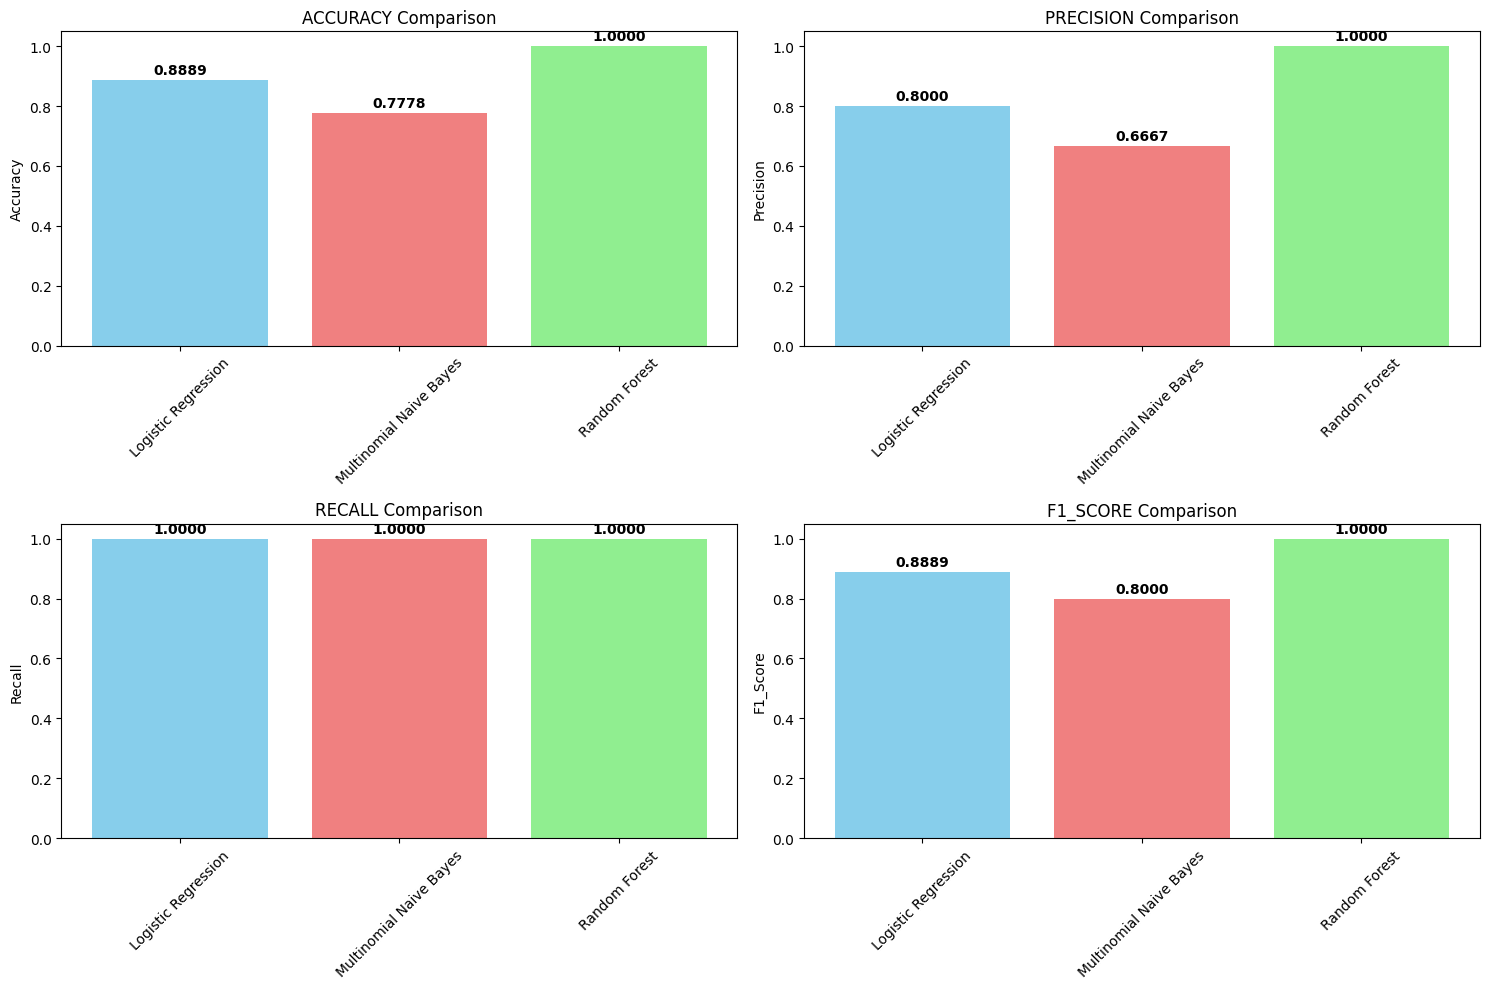

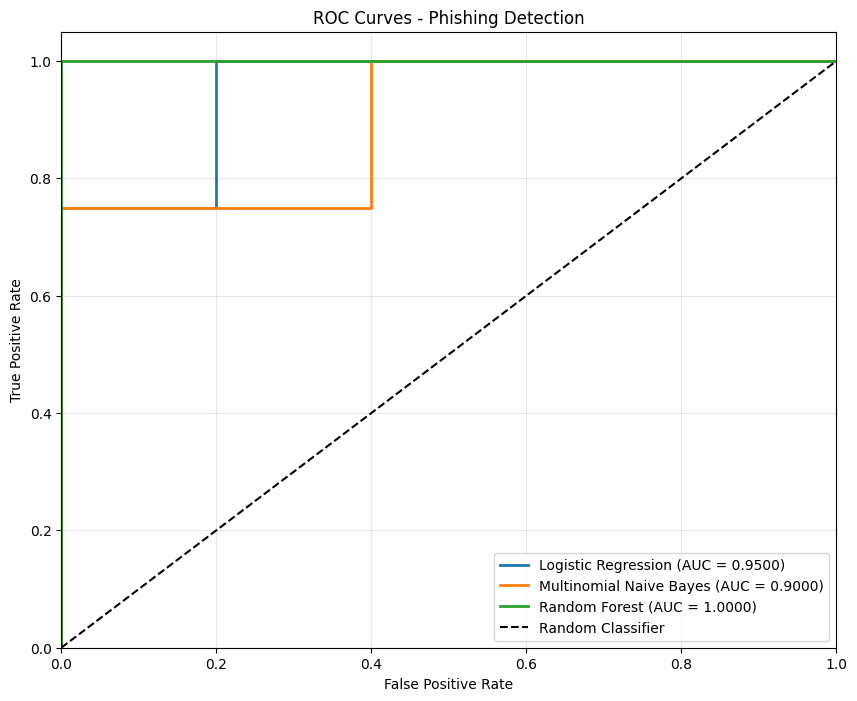

In [8]:
# Visualizations
print("📊 Creating Visualizations")
print("=" * 50)

# 1. Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (name, result) in enumerate(results.items()):
    cm = confusion_matrix(y_test, result['predictions'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Legitimate', 'Phishing'],
                yticklabels=['Legitimate', 'Phishing'])
    axes[idx].set_title(f'{name}\nConfusion Matrix')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# 2. Performance Comparison
metrics = ['accuracy', 'precision', 'recall', 'f1_score']
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for i, metric in enumerate(metrics):
    values = [results[model][metric] for model in results.keys()]
    bars = axes[i].bar(results.keys(), values, color=['skyblue', 'lightcoral', 'lightgreen'])
    axes[i].set_title(f'{metric.upper()} Comparison')
    axes[i].set_ylabel(metric.title())
    axes[i].tick_params(axis='x', rotation=45)

    # Add value labels on bars
    for bar, v in zip(bars, values):
        axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# 3. ROC Curves
plt.figure(figsize=(10, 8))
for name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result['probabilities'])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.4f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Phishing Detection')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

🔍 EXPLORATORY DATA ANALYSIS


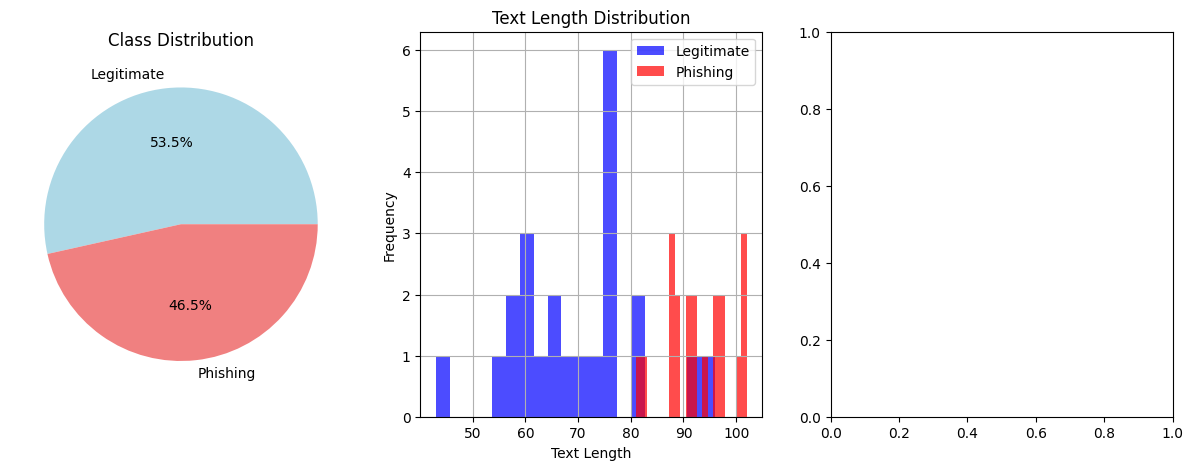

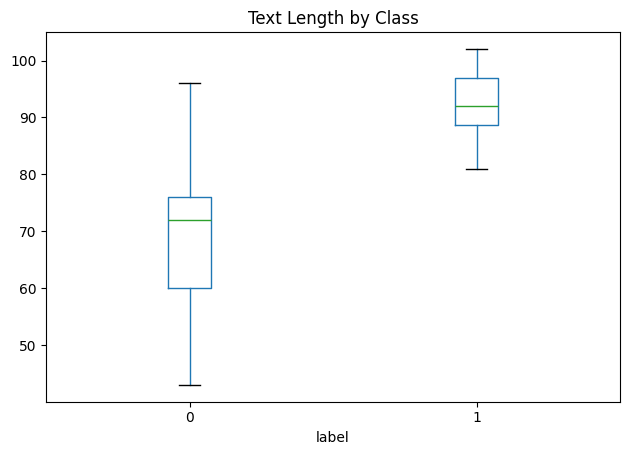


📏 Text Length Statistics:
       count       mean        std   min    25%   50%   75%    max
label                                                             
0       23.0  69.826087  12.360686  43.0  60.00  72.0  76.0   96.0
1       20.0  92.900000   6.086223  81.0  88.75  92.0  97.0  102.0


In [9]:
# Exploratory Data Analysis
print("🔍 EXPLORATORY DATA ANALYSIS")
print("=" * 50)

# Class distribution
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
class_dist = df['label'].value_counts()
colors = ['lightblue', 'lightcoral']
plt.pie(class_dist.values, labels=['Legitimate', 'Phishing'], autopct='%1.1f%%', colors=colors)
plt.title('Class Distribution')

# Text length analysis
df['text_length'] = df['text'].apply(len)

plt.subplot(1, 3, 2)
df[df['label'] == 0]['text_length'].hist(alpha=0.7, label='Legitimate', color='blue', bins=20)
df[df['label'] == 1]['text_length'].hist(alpha=0.7, label='Phishing', color='red', bins=20)
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Text Length Distribution')
plt.legend()

plt.subplot(1, 3, 3)
df.boxplot(column='text_length', by='label', grid=False)
plt.title('Text Length by Class')
plt.suptitle('')

plt.tight_layout()
plt.show()

# Text length statistics
print("\n📏 Text Length Statistics:")
print(df.groupby('label')['text_length'].describe())

🔍 Feature Importance Analysis


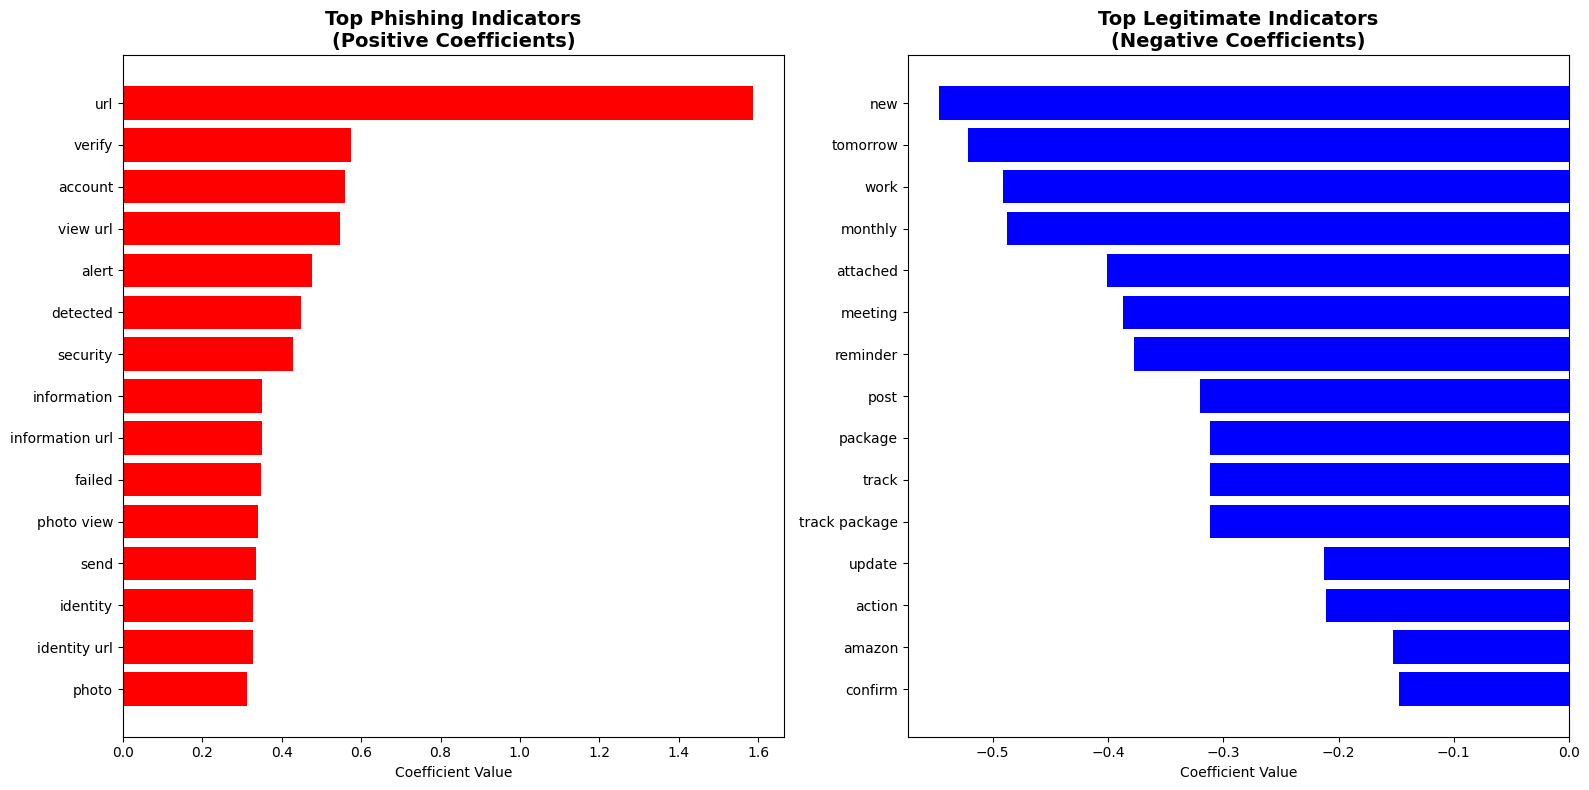

📋 Top 10 Phishing Keywords:
  • url: 1.5860
  • verify: 0.5754
  • account: 0.5593
  • view url: 0.5478
  • alert: 0.4764
  • detected: 0.4494
  • security: 0.4282
  • information: 0.3515
  • information url: 0.3515
  • failed: 0.3469

📋 Top 10 Legitimate Keywords:
  • new: -0.5463
  • tomorrow: -0.5212
  • work: -0.4912
  • monthly: -0.4876
  • attached: -0.4005
  • meeting: -0.3872
  • reminder: -0.3776
  • post: -0.3205
  • package: -0.3111
  • track: -0.3111


In [10]:
# Feature Importance Analysis
print("🔍 Feature Importance Analysis")
print("=" * 50)

# Get the best model (Logistic Regression for interpretability)
best_model = trained_models['Logistic Regression']
feature_names = vectorizer.get_feature_names_out()

# Get coefficients
coefficients = best_model.coef_[0]
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients,
    'abs_coefficient': abs(coefficients)
})

# Top features for phishing (positive coefficients)
top_phishing_features = feature_importance.nlargest(15, 'coefficient')
# Top features for legitimate (negative coefficients)
top_legitimate_features = feature_importance.nsmallest(15, 'coefficient')

# Plot top features
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Phishing indicators
ax1.barh(top_phishing_features['feature'], top_phishing_features['coefficient'], color='red')
ax1.set_title('Top Phishing Indicators\n(Positive Coefficients)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Coefficient Value')
ax1.invert_yaxis()

# Legitimate indicators
ax2.barh(top_legitimate_features['feature'], top_legitimate_features['coefficient'], color='blue')
ax2.set_title('Top Legitimate Indicators\n(Negative Coefficients)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Coefficient Value')
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

print("📋 Top 10 Phishing Keywords:")
for idx, row in top_phishing_features.head(10).iterrows():
    print(f"  • {row['feature']}: {row['coefficient']:.4f}")

print("\n📋 Top 10 Legitimate Keywords:")
for idx, row in top_legitimate_features.head(10).iterrows():
    print(f"  • {row['feature']}: {row['coefficient']:.4f}")

In [11]:
# Real-time Prediction Function
def predict_phishing(text, model, vectorizer, preprocessor):
    """Predict if a text is phishing or legitimate"""

    # Preprocess the text
    cleaned_text = preprocessor.preprocess_text(text)

    # Transform to features
    text_features = vectorizer.transform([cleaned_text])

    # Make prediction
    prediction = model.predict(text_features)[0]
    probability = model.predict_proba(text_features)[0]

    result = {
        'text': text,
        'prediction': '🚨 PHISHING' if prediction == 1 else '✅ LEGITIMATE',
        'phishing_probability': f"{probability[1]:.4f}",
        'legitimate_probability': f"{probability[0]:.4f}",
        'confidence': f"{max(probability):.4f}"
    }

    return result

# Test with new examples
print("🎯 Testing with Real Examples")
print("=" * 60)

test_examples = [
    "URGENT: Your bank account will be closed today. Verify immediately: http://fake-bank-security.com",
    "Hi team, meeting tomorrow at 3 PM in the main conference room.",
    "Congratulations! You won a free iPhone. Claim now: http://free-gift-reward.com",
    "Your package delivery is scheduled for tomorrow. Track here: https://ups.com/track/123",
    "Security alert: Unusual login from new device. Secure your account now!",
    "Your Netflix subscription has expired. Update payment method: http://netflix-billing-update.net"
]

# Use Logistic Regression model for prediction
model = trained_models['Logistic Regression']

for i, text in enumerate(test_examples, 1):
    result = predict_phishing(text, model, vectorizer, preprocessor)
    print(f"\nExample {i}:")
    print(f"Text: {text}")
    print(f"Prediction: {result['prediction']}")
    print(f"Phishing Probability: {result['phishing_probability']}")
    print(f"Legitimate Probability: {result['legitimate_probability']}")
    print(f"Confidence: {result['confidence']}")
    print("-" * 80)

🎯 Testing with Real Examples

Example 1:
Text: URGENT: Your bank account will be closed today. Verify immediately: http://fake-bank-security.com
Prediction: 🚨 PHISHING
Phishing Probability: 0.7162
Legitimate Probability: 0.2838
Confidence: 0.7162
--------------------------------------------------------------------------------

Example 2:
Text: Hi team, meeting tomorrow at 3 PM in the main conference room.
Prediction: ✅ LEGITIMATE
Phishing Probability: 0.2554
Legitimate Probability: 0.7446
Confidence: 0.7446
--------------------------------------------------------------------------------

Example 3:
Text: Congratulations! You won a free iPhone. Claim now: http://free-gift-reward.com
Prediction: 🚨 PHISHING
Phishing Probability: 0.6160
Legitimate Probability: 0.3840
Confidence: 0.6160
--------------------------------------------------------------------------------

Example 4:
Text: Your package delivery is scheduled for tomorrow. Track here: https://ups.com/track/123
Prediction: ✅ LEGITIM

In [12]:
# ============================================
# Model Saving & Download (Colab + Local Safe)
# ============================================

print("💾 Saving the Model")
print("=" * 60)

import joblib
import pickle
import os

# --------------------------------------------
# REQUIRED VARIABLES (must already exist)
# --------------------------------------------
# trained_models['Logistic Regression']
# vectorizer
# preprocessor
# df  --> pandas DataFrame (dataset)

# --------------------------------------------
# Prepare model bundle
# --------------------------------------------
model_data = {
    "model": trained_models["Logistic Regression"],
    "vectorizer": vectorizer,
    "preprocessor": preprocessor
}

# --------------------------------------------
# Save model using joblib
# --------------------------------------------
joblib.dump(model_data, "phishing_detector_model.pkl")
print("✅ Model saved as 'phishing_detector_model.pkl'")

# --------------------------------------------
# Save model using pickle
# --------------------------------------------
with open("phishing_detector_model.pickle", "wb") as f:
    pickle.dump(model_data, f)
print("✅ Model saved as 'phishing_detector_model.pickle'")

# --------------------------------------------
# Save dataset
# --------------------------------------------
df.to_csv("phishing_dataset.csv", index=False)
print("✅ Dataset saved as 'phishing_dataset.csv'")

# --------------------------------------------
# Show current directory (Local usage)
# --------------------------------------------
print("\n📂 Files saved at:", os.getcwd())
print("📄 Saved files:", os.listdir())

# --------------------------------------------
# Download files ONLY if running in Google Colab
# --------------------------------------------
try:
    from google.colab import files

    files.download("phishing_detector_model.pkl")
    files.download("phishing_dataset.csv")
    print("\n📥 Files downloaded successfully (Colab)")
except ImportError:
    print("\nℹ️ Not running in Google Colab.")
    print("➡️ Files are already available locally.")


💾 Saving the Model
✅ Model saved as 'phishing_detector_model.pkl'
✅ Model saved as 'phishing_detector_model.pickle'
✅ Dataset saved as 'phishing_dataset.csv'

📂 Files saved at: c:\Users\krish\Desktop\Phishing-Word-Detection-using-Text-Analysis
📄 Saved files: ['.git', 'phishing_dataset.csv', 'Phishing_Detection_in_Google_Colab.ipynb', 'phishing_detector_model.pickle', 'phishing_detector_model.pkl', 'README.md']

ℹ️ Not running in Google Colab.
➡️ Files are already available locally.


In [13]:
# Load and Use Saved Model (for demonstration)
print("🔄 Loading and Testing Saved Model")
print("=" * 50)

# Load the model
loaded_model_data = joblib.load('phishing_detector_model.pkl')
loaded_model = loaded_model_data['model']
loaded_vectorizer = loaded_model_data['vectorizer']
loaded_preprocessor = loaded_model_data['preprocessor']

# Test the loaded model
test_text = "URGENT: Verify your bank account now to avoid suspension!"
result = predict_phishing(test_text, loaded_model, loaded_vectorizer, loaded_preprocessor)

print("🧪 Test with loaded model:")
print(f"Text: {test_text}")
print(f"Prediction: {result['prediction']}")
print(f"Phishing Probability: {result['phishing_probability']}")
print(f"Confidence: {result['confidence']}")

print("\n✅ Model loading and prediction successful!")

🔄 Loading and Testing Saved Model
🧪 Test with loaded model:
Text: URGENT: Verify your bank account now to avoid suspension!
Prediction: 🚨 PHISHING
Phishing Probability: 0.5895
Confidence: 0.5895

✅ Model loading and prediction successful!


☁️ Generating Word Clouds


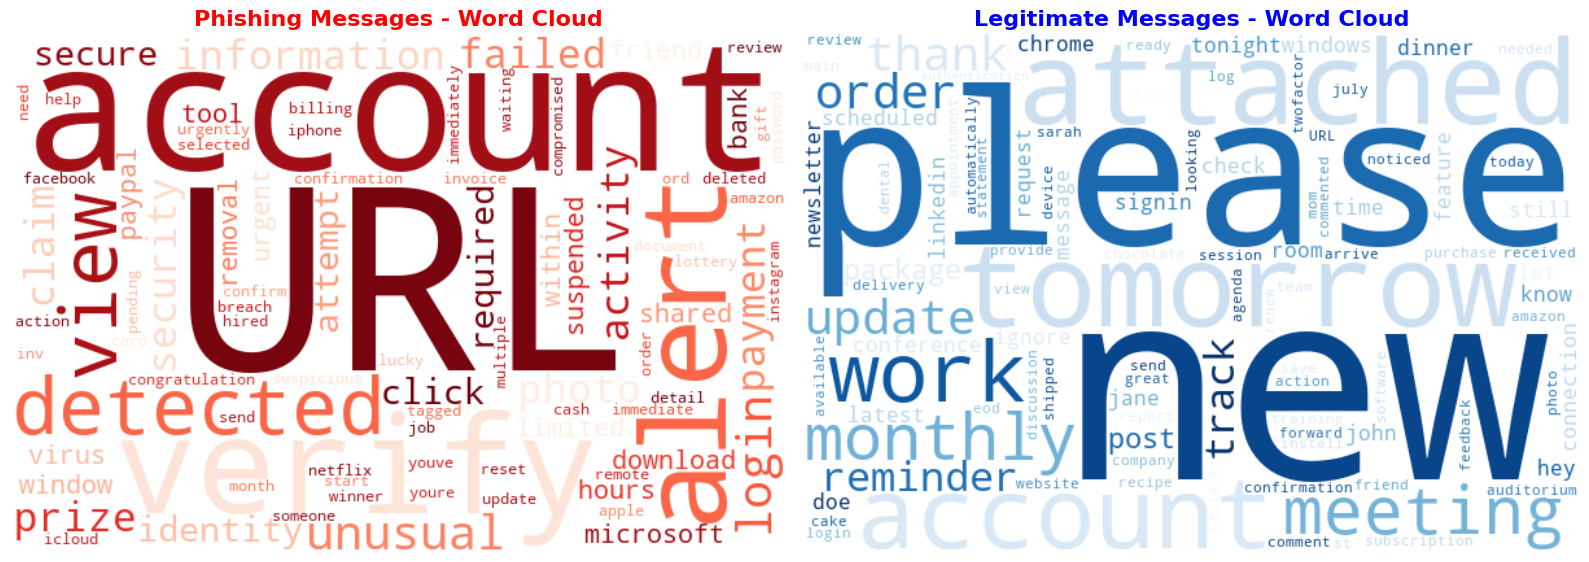

In [15]:
# Word Clouds
print("☁️ Generating Word Clouds")
print("=" * 50)

# Create word clouds for phishing and legitimate messages
phishing_texts = ' '.join(df[df['label'] == 1]['cleaned_text'])
legitimate_texts = ' '.join(df[df['label'] == 0]['cleaned_text'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Phishing word cloud
wordcloud_phishing = WordCloud(
    width=600, height=400,
    background_color='white',
    colormap='Reds',
    max_words=100,
    contour_width=1,
    contour_color='red'
).generate(phishing_texts)

ax1.imshow(wordcloud_phishing, interpolation='bilinear')
ax1.set_title('Phishing Messages - Word Cloud', fontsize=16, fontweight='bold', color='red')
ax1.axis('off')

# Legitimate word cloud
wordcloud_legit = WordCloud(
    width=600, height=400,
    background_color='white',
    colormap='Blues',
    max_words=100,
    contour_width=1,
    contour_color='blue'
).generate(legitimate_texts)

ax2.imshow(wordcloud_legit, interpolation='bilinear')
ax2.set_title('Legitimate Messages - Word Cloud', fontsize=16, fontweight='bold', color='blue')
ax2.axis('off')

plt.tight_layout()
plt.show()